In [1]:
# Copyright (c) Nanjing University, Vision Lab.
# Jianqiang Wang (wangjq@smail.nju.edu.cn), Hao Zhu, Zhan Ma, Tong Chen, Haojie Liu, Qiu Shen; Nanjing University, Vision Lab.
# Chaofei Wang; Shanghai Jiao Tong University, Cooperative Medianet Innovation Center.
# Last update: 2019.10.22
# 2019.11.14
# 2019.11.22 check bug

In [2]:
import os
import time
import numpy as np
import tensorflow as tf
import matplotlib.pylab  as plt
import pandas as pd
tf.enable_eager_execution()

/home/ubuntu/anaconda3/envs/tf/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:526: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/home/ubuntu/anaconda3/envs/tf/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:527: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/home/ubuntu/anaconda3/envs/tf/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:528: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/home/ubuntu/anaconda3/envs/tf/lib/python3.6/site-packages

In [3]:
print(tf.test.is_gpu_available())

False


In [4]:
from mycodec_factorized import preprocess, postprocess, compress, decompress, \
write_binary_files, read_binary_files

### set gpu/cpu

In [5]:
# os.environ['CUDA_VISIBLE_DEVICES']="" # only cpu

config = tf.ConfigProto()
config.gpu_options.per_process_gpu_memory_fraction = 0.5
config.gpu_options.allow_growth = True
config.log_device_placement=True
# config.device_count={'gpu':0}
sess = tf.Session(config=config)

---
## Compression


###  Pre-process

In [6]:
input_file = 'testdata/8iVFB/longdress_vox10_1300.ply'
scale = 1.
cube_size = 64
min_num = 64
res = 1024

In [7]:
cubes, cube_positions, points_numbers = preprocess(input_file, scale, cube_size, min_num)

===== Preprocess =====
Scaling: 0.0s
Partition: 11.156s
Voxelization: 0.1682s
cubes shape: (202, 64, 64, 64, 1)
points numbers (sum/mean/max/min): 857600 4246 11450 78


point_numbers (min/max/mean):  78 11450 4245.544554455446


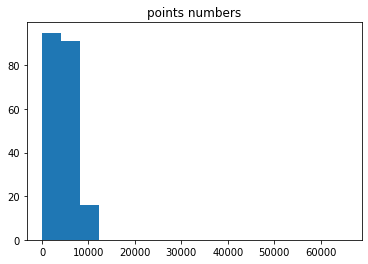

In [8]:
print('point_numbers (min/max/mean): ', points_numbers.min(), points_numbers.max(), points_numbers.mean())
plt.title('points numbers')
n, bins, patches = plt.hist(points_numbers, bins=16, range=(1, pow(2, 16)))
plt.show()

### encoding

In [9]:
# model = 'model_voxception'
import models.model_voxception as model
ckpt_dir = './checkpoints/factorized/a2b3/'

In [10]:
start = time.time()
strings, min_v, max_v, shape = compress(cubes, model, ckpt_dir)
print(time.time() - start)

===== Compress =====
Instructions for updating:
Colocations handled automatically by placer.
Analysis Transform: 113.1422s
Entropy Encode: 0.1082s
113.4429030418396


In [11]:
print(min_v.numpy(), max_v.numpy(), shape.numpy())

-2 2 [202  16  16  16  16]


### Write files

In [12]:
filename = os.path.split(input_file)[-1][:-4]
rootdir = './compressed/'
print(rootdir, filename)

bytes_strings, bytes_pointnums, bytes_cubepos = write_binary_files(
    filename, strings.numpy(), points_numbers, cube_positions,
    min_v.numpy(), max_v.numpy(), shape.numpy(), rootdir)

./compressed/ longdress_vox10_1300
===== Write binary files =====
Total file size (Bytes): 13960
Strings (Bytes): 13466
Numbers of points (Bytes): 404
Positions of cubes (Bytes): 90


In [13]:
import subprocess
subp=subprocess.Popen("ls ./compressed/", 
                      shell=True, stdout=subprocess.PIPE)

c=subp.stdout.readline()
while c:
    print (c)
    c=subp.stdout.readline()


b'longdress_vox10_1300.cubepos\n'
b'longdress_vox10_1300_cubepos.ply\n'
b'longdress_vox10_1300.pointnums\n'
b'longdress_vox10_1300.strings\n'


---
## Decompress

### Read files

In [14]:
strings_d, points_numbers_d, cube_positions_d, min_v_d, max_v_d, shape_d = read_binary_files(filename, rootdir)

===== Read binary files =====


### decoding

In [15]:
cubes_d = decompress(strings_d, min_v_d, max_v_d, shape_d, model, ckpt_dir)

===== Decompress =====
Entropy Decode: 0.1576s
Synthesis Transform: 119.4757s


### post-process

In [16]:
rho = 1.0
output_file = filename + "_rec.ply"

postprocess(output_file, cubes_d, points_numbers_d, cube_positions_d, scale, cube_size, rho)

===== Post process =====
Classify and extract points: 0.5296s
Write point cloud to longdress_vox10_1300_rec.ply: 3.4438s


---
## Metrics

### bpp

In [17]:
def get_points_number(filedir):
    plyfile = open(filedir)

    line = plyfile.readline()
    while line.find("element vertex") == -1:
        line = plyfile.readline()
    number = int(line.split(' ')[-1][:-1])
    
    return number

In [18]:
N = get_points_number(input_file)
print(N)

857966


In [19]:
print("bpp: ", 8*(bytes_strings + bytes_pointnums + bytes_cubepos)/float(N))
print("strings: ", 8*bytes_strings/float(N), "points numbers: ", 8*bytes_pointnums/float(N), \
"cubes positions: ", 8*bytes_cubepos/float(N))

bpp:  0.1301683283486758
strings:  0.12556208521083587 points numbers:  0.0037670490439015067 cubes positions:  0.0008391940939384545


### pc_error

In [20]:
import subprocess

subp=subprocess.Popen("myutils/pc_error_d" 
                      + ' -a ' + input_file
                      + ' -b ' + output_file
                      +' -n ' + input_file 
                      + ' --hausdorff=1 '
                      + " -r "+str(res-1), 
                      shell=True, stdout=subprocess.PIPE)

c=subp.stdout.readline()
while c:
    print(c)
    c=subp.stdout.readline()

print(subp.returncode)

b'PCC quality measurement software, version 0.13.4\n'
b'\n'
b'infile1:        testdata/8iVFB/longdress_vox10_1300.ply\n'
b'infile2:        longdress_vox10_1300_rec.ply\n'
b'normal1:        testdata/8iVFB/longdress_vox10_1300.ply\n'
b'singlePass:     0\n'
b'hausdorff:      1\n'
b'color:          0\n'
b'lidar:          0\n'
b'resolution:     1023\n'
b'dropDuplicates: 2\n'
b'neighborsProc:  1\n'
b'averageNormals: 1\n'
b'nbThreads:      1\n'
b'\n'
b'Verifying if the data is loaded correctly.. The last point is: 256 902 320\n'
b'Reading file 1 done.\n'
b'Normals loaded from file1.\n'
b'Verifying if the data is loaded correctly.. The last point is: 223 960 320\n'
b'Reading file 2 done.\n'
b'Imported intrinsic resoluiton: 1023\n'
b'Peak distance for PSNR: 1023\n'
b'Point cloud sizes for org version, dec version, and the scaling ratio: 857966, 857398, 0.999338\n'
b'Normals prepared.\n'
b'\n'
b'1. Use infile1 (A) as reference, loop over A, use normals on B. (A->B).\n'
b'   mse1      (p2point): 

In [21]:
import open3d as o3d

pcd = o3d.io.read_point_cloud(input_file)

In [22]:
o3d.visualization.draw_geometries([pcd])

In [23]:
pcd_rec = o3d.io.read_point_cloud(output_file)
o3d.visualization.draw_geometries([pcd_rec])